In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Concatenate, Conv1D, Lambda, Add, Activation
from tensorflow.keras.metrics import *

In [32]:
class Model(tf.keras.Model):

    def __init__(self):
        super(Model, self).__init__()
        self.base_blocks = self.init_base_block()
        self.concat = tf.concat
        self.copy = tf.identity
        self.num_units = [1, 4, 7, 22, 56, 43]
        self.inter_blocks = [self.init_kth_inter_block(k, self.num_units[k]) for k in range(6)]
        self.out_blocks = [self.init_kth_out_block(k, self.num_units[k]) for k in range(6)]
        self.postproc_layers = [self.init_kth_post_proc_layer(k) for k in range(6)]

    def init_kth_inter_block(self, k: int, out_units):
        filter_by_size = lambda x: x[ (x > out_units * 8) & (x <= out_units * 32)][::-1]
        num_units = filter_by_size(2 ** np.arange(11))
        # modify here
        block = tf.keras.Sequential()
        block.add(Dense(num_units[0], name='l'+str(k)+'_inter_dense_0', input_shape=(512,), use_bias=False, kernel_initializer=ln_init))
        block.add(BatchNormalization())
        block.add(Activation('relu'))
        block.add(Dense(num_units[1], name='l'+str(k)+'_inter_dense_1', use_bias=False, kernel_initializer=ln_init))
        block.add(BatchNormalization())
        block.add(Activation('relu'))
        return block

    def init_kth_out_block(self, k: int, out_units):
        n_units = 2 ** np.arange(0, 11)[::-1]
        n_units = n_units[(n_units > (4 * out_units)).sum() + 1]
        # modify here
        block = tf.keras.Sequential()
        block.add(Dense(n_units, name='l'+str(k)+'_out_dense_0', use_bias=False, kernel_initializer=ln_init,
                kernel_regularizer='l2'))
        block.add(BatchNormalization())
        block.add(Activation('relu'))
        block.add(Dense(n_units, name='l'+str(k)+'_out_dense_1', use_bias=False, kernel_initializer=ln_init,
                kernel_regularizer='l2'))
        block.add(BatchNormalization())
        block.add(Activation('relu'))
        block.add(Dense(n_units, name='l'+str(k)+'_out_dense_1', use_bias=False, kernel_initializer=ln_init,
                kernel_regularizer='l2'))
        block.add(BatchNormalization())
        block.add(Activation('relu'))
        block.add(Dense(out_units, name='l'+str(k), activation='sigmoid', use_bias=False))
        return block

    def init_base_block(self):
        block = tf.keras.Sequential()
        block.add(Conv1D(64, kernel_size=2, strides=1, padding='same', activation='relu', 
                          kernel_initializer=ln_init, use_bias=False, input_shape=(1462, 7)))
        block.add(Conv1D(64, kernel_size=2, strides=2, activation='relu', kernel_initializer=ln_init, use_bias=False))
        block.add(Conv1D(128, kernel_size=3, strides=2, activation='relu', kernel_initializer=ln_init, use_bias=False))
        block.add(Conv1D(128, kernel_size=3, strides=2, activation='relu', kernel_initializer=ln_init, use_bias=False))
        block.add(Conv1D(256, kernel_size=2, strides=2, activation='relu', kernel_initializer=ln_init, use_bias=False))
        block.add(Conv1D(256, kernel_size=4, strides=3, activation='relu', kernel_initializer=ln_init, use_bias=False))
        block.add(Conv1D(512, kernel_size=2, strides=2, activation='relu', kernel_initializer=ln_init, use_bias=False))
        block.add(Conv1D(512, kernel_size=3, strides=2, activation='relu', kernel_initializer=ln_init, use_bias=False,
                          kernel_regularizer='l2'))
        block.add(Conv1D(512, kernel_size=7, strides=1, use_bias=False, kernel_initializer=ln_init, kernel_regularizer='l2'))
        block.add(BatchNormalization())
        block.add(Activation('relu'))
        block.add(Flatten())
        return block

    def init_kth_post_proc_layer(self, k):
        def scale_output(x):
            total_contrib = tf.constant([[1]], dtype=tf.float32, shape=(1, 1))
            unknown_contrib = tf.subtract(total_contrib, tf.keras.backend.sum(x, keepdims=True, axis=1))
            contrib = tf.keras.backend.relu(tf.keras.backend.concatenate( (x, unknown_contrib), axis=1))
            scaled_contrib = tf.divide(contrib, tf.keras.backend.sum(contrib, keepdims=True, axis=1))
            return scaled_contrib
        return Lambda(scale_output, name='l'+str(k)+'_y')

    def call(self, input, training=False):
        base = self.base_blocks(input, training=training)
        inter_factors = [self.inter_blocks[i](base, training=training) for i in range(6)]
        concat_factors = [self.concat(inter_factors[0:i], axis=1) for i in range(1, 7)]
        y_s = [self.out_blocks[i](concat_factors[i], training=training) for i in range(6)]
        (l0_y, l1_y, l2_y, l3_y, l4_y, l5_y) = (self.postproc_layers[i](y_s[i], training=training) for i in range(6))
        return l0_y, l1_y, l2_y, l3_y, l4_y, l5_y

In [33]:
ln_init = tf.keras.initializers.GlorotUniform()
model = Model()
model.build(input_shape=(None, 1462, 7))
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_150 (Sequential)  (None, 512)               3296128   
_________________________________________________________________
sequential_151 (Sequential)  (None, 16)                17088     
_________________________________________________________________
sequential_152 (Sequential)  (None, 64)                74496     
_________________________________________________________________
sequential_153 (Sequential)  (None, 64)                74496     
_________________________________________________________________
sequential_154 (Sequential)  (None, 256)               396288    
_________________________________________________________________
sequential_155 (Sequential)  (None, 512)               1054720   
_________________________________________________________________
sequential_156 (Sequential)  (None, 512)               105

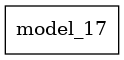

In [34]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)